# Visualizing Data with Dimensionality Reduction Techniques 

In this walkthrough, you'll learn how to run PCA, t-SNE, UMAP, and custom dimensionality reduction techniques on your data in FiftyOne!

It covers the following:

- Why dimensionality reduction is useful
- Strengths and weaknesses of different dimensionality reduction techniques
- Running built-in dimensionality reduction techniques in FiftyOne
- Running custom dimensionality reduction techniques in FiftyOne

## Why Dimensionality Reduction?

These days, everyone is excited about embeddings — numeric vectors that represent features of your input data. In computer vision for instance, image embeddings are used in reverse image search applications. And in the context of large language models (LLMs), documents are chunked and embedded (with text embedding models) for retrieval augmented generation (RAG).

Embeddings are incredibly powerful, but given their high dimensionality (with lengths typically between 384 and 4096), they can be hard for humans to interpret and inspect. This is where dimensionality reduction techniques come in handy!

Dimensionality reduction techniques are quantitative methods for representing information from a higher dimensional space in a lower dimensional space. By squeezing our embeddings into two or three dimensions, we can visualize them to get a more intuitive understanding of the “hidden” structure in our data.

When we project high dimensional data into a low dimensional space, we implicitly make a trade-off between representational complexity and interpretability. To compress embeddings, dimensionality reduction techniques make assumptions about the underlying data, its distribution, and the relationships between variables.

In this post, we will visualize embeddings using four popular dimensionality reduction techniques: PCA, t-SNE, and UMAP. We will give a brief overview of the strengths, weaknesses, and assumptions of each technique. And we will illustrate that both the model used to generate embeddings, and the dimensionality reduction technique play essential roles in shaping the visualization of your data.

*It is also important to note that dimensionality reduction techniques often have hyperparameters, which can have non-negligible impacts on the results. In this post, I am going to use the default hyperparameters everywhere that choices arise. Feel free to modify as you see fit!*

## Setup

For this walkthrough, we will be using the FiftyOne library for data management and visualization. We will use [scikit-learn](https://scikit-learn.org/stable/) for PCA and t-SNE, and [umap-learn](https://umap-learn.readthedocs.io/en/latest/#) for UMAP dimension reduction implementations:

In [ ]:
!pip install -U fiftyone scikit-learn umap-learn

We will be using the test split of the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset as our testbed, which contains 10,000 images of size 32x32 pixels, spanning 10 image classes. We can load the dataset/split directly from the [FiftyOne Dataset Zoo](https://docs.voxel51.com/user_guide/dataset_zoo/datasets.html):


In [ ]:
import fiftyone as fo
import fiftyone.brain as fob
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("cifar10", split="test")
session = fo.launch_app(dataset)

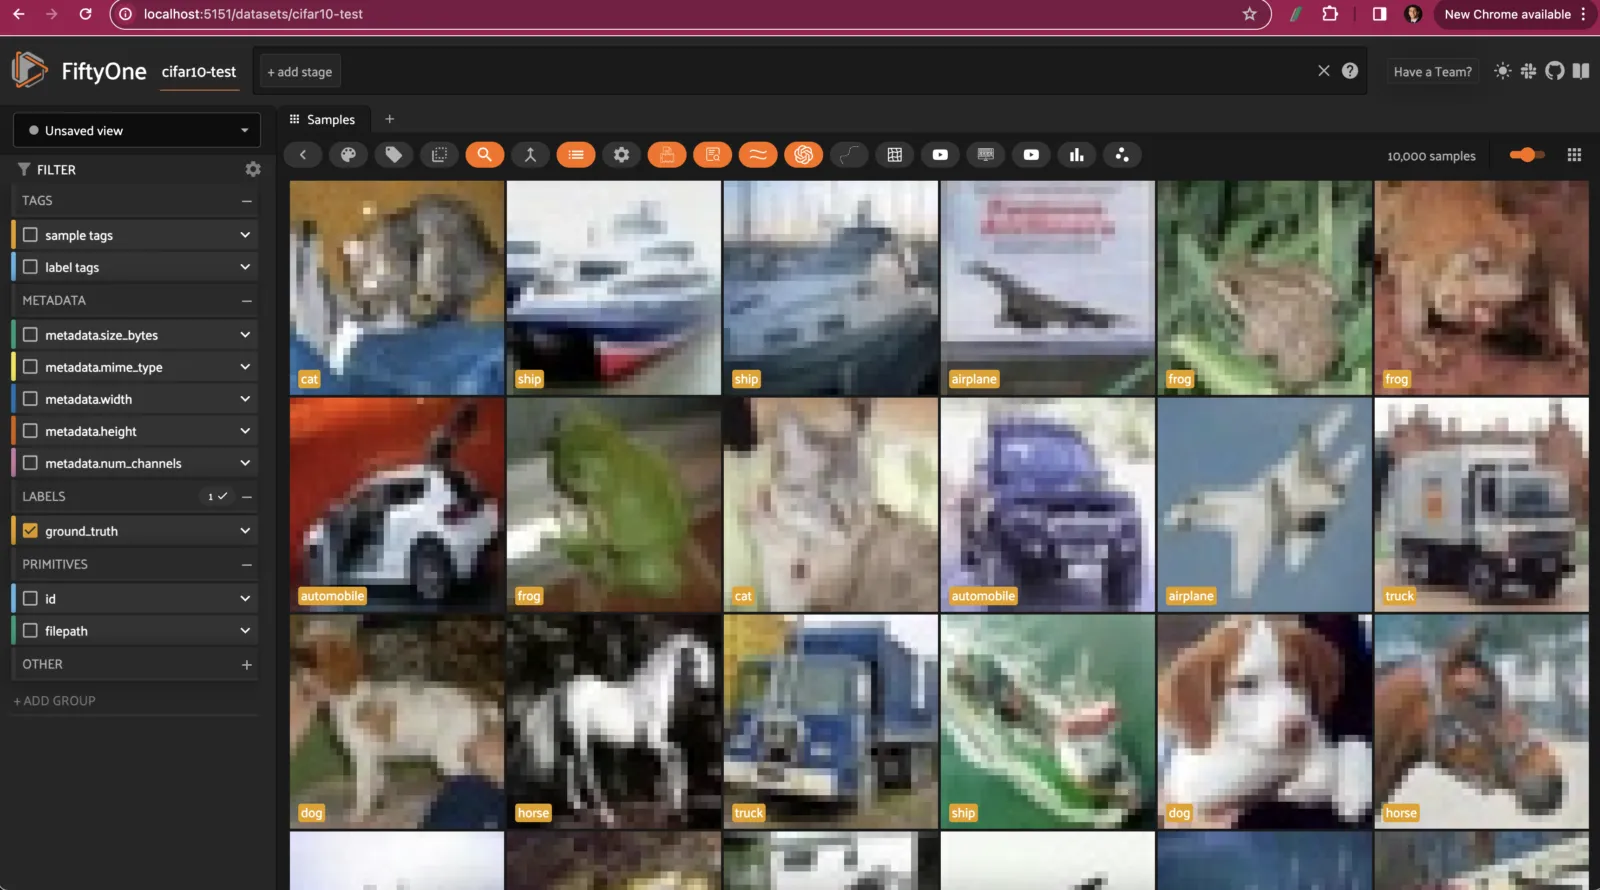

We will compare and contrast our four dimensionality reduction techniques with two image embedding models: [ResNet-101](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet101.html) and [CLIP](https://github.com/openai/CLIP). Whereas ResNet-101 is a more traditional vision model, representing the relationships between pixels and patches in images, CLIP captures more of the semantic content of the images.

We can load both from the [FiftyOne Model Zoo](https://docs.voxel51.com/user_guide/model_zoo/index.html):

In [ ]:
clip = foz.load_zoo_model("clip-vit-base32-torch")
resnet101 = foz.load_zoo_model("resnet101-imagenet-torch")

Then generating embeddings for each model amounts to making a single call to the dataset’s `compute_embeddings()` method:

In [ ]:
## compute and store resnet101 embeddings 
dataset.compute_embeddings(
    resnet101, 
    embeddings_field="resnet101_embeddings"
)

## compute and store clip embeddings 
dataset.compute_embeddings(
    clip, 
    embeddings_field="clip_embeddings"
)

## Dimensionality Reduction API in FiftyOne

Before we dive into the details of each dimensionality reduction technique, let’s recap the API for running dimensionality reduction in FiftyOne. The [FiftyOne Brain](https://docs.voxel51.com/user_guide/brain.html) provides a [compute_visualization()](https://docs.voxel51.com/api/fiftyone.brain.html#fiftyone.brain.compute_visualization) function that can be used to run dimensionality reduction on your data.

The first and only positional argument to this function is a sample collection, which can be either a [Dataset](https://docs.voxel51.com/user_guide/using_datasets.html#datasets) or a [DatasetView](https://docs.voxel51.com/user_guide/using_views.html).

Beyond that, you need to specify the following three things:
1. *What* you want to reduce the dimensionality of.
2. *How* you want to reduce the dimensionality.
3. *Where* you want to store the results.

### What to reduce the dimensionality of

There are multiple ways to specify what you would like dimension-reduced. Here are a few options (but certainly not all of them!):

- You can specify the name of the field containing the embeddings you would like to reduce using the `embeddings` argument. If your embeddings are stored in field "my_embeddings_field" on your samples, you would employ the syntax `embeddings="my_embeddings_field"`. This is useful if you need to reuse the same embeddings for multiple dimensionality reduction techniques, or for other brain methods.
- You can pass the embeddings in directly using as numpy array, also via the `embeddings` argument. This is useful if you have already computed your embeddings, and don’t need to store them on your samples.
- You can specify the *model* you would like to use to generate embeddings. This can be:
    - A `FiftyOne.Model` instance
    - The name (a string) of a model from the model zoo, in which case the model by that will be loaded from the FiftyOne Model Zoo.
    - A Hugging Face Transformers model, in which case the model will be converted to a `FiftyOne.Model` instance. See the [Hugging Face integration docs](https://docs.voxel51.com/integrations/huggingface.html) for more details.

### How to reduce the dimensionality

You can specify the base dimensionality reduction technique to use via the `method` argument. This can be one of the following strings: `pca`, `tsne`, `umap`, or `manual`.

For `pca`, `tsne`, and `umap`, you can specify the number of dimensions to reduce to via the `num_dims` argument. Additionally, you can specify hyperparameters for each technique as kwargs. For a complete description of available options, check out the visualization configs: 
[TSNEVisualizationConfig](https://docs.voxel51.com/api/fiftyone.brain.visualization.html#fiftyone.brain.visualization.TSNEVisualizationConfig),
[UMAPVisualizationConfig](https://docs.voxel51.com/api/fiftyone.brain.visualization.html#fiftyone.brain.visualization.UMAPVisualizationConfig), and [PCAVisualizationConfig](https://docs.voxel51.com/api/fiftyone.brain.visualization.html#fiftyone.brain.visualization.PCAVisualizationConfig).

You can use `method="manual"` if you already have the dimensionality-reduced data, and just want to store it on your samples for visualization purposes.

### Where to store the results

Once you have specified what you want to reduce the dimensionality of, and how you want to do it, you need to specify where you want to store the results. This is done via the `brain_key` argument. Once you have run the `compute_visualization()` method, you will be able to select this brain key in the FiftyOne App to visualize the results. You can also use the brain key to access the results programmatically:

In [ ]:
import fiftyone as fo
import fiftyone.brain as fob
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("cifar10", split="test")

## Compute PCA visualization
fob.compute_visualization(
    dataset,
    embeddings="resnet101",
    method="pca",
    brain_key="pca_resnet101"
)

## Access results
pca_resnet_results = dataset.load_brain_results("pca_resnet101")

## Dimensionality Reduction with PCA

[Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis), or PCA, is a dimensionality reduction technique that seeks to preserve as much variance as possible. Intuitively, PCA finds a set of orthogonal axes (principal components) that jointly “explain” as much of the variation in the data as possible. Mathematically, you can interpret PCA algorithms as effectively performing singular value decompositions and truncating the number of dimensions by eliminating the singular vectors with the smallest eigenvalues.

**Strengths**

- Simple, intuitive, and efficient for large datasets! 
- PCA is amenable to new data: If you have precomputed the transformation on an initial set of embeddings, you can apply that transformation to new embeddings and immediately visualize them in the same space.

**Limitations**

- Assumes that the relationships between variables are linear — an assumption which often does not hold when the inputs are embeddings, which themselves come from highly nonlinear deep neural networks
- Very susceptible to outliers.

### Running PCA on Embeddings

PCA is natively supported by the FiftyOne Brain’s `compute_visualization()`. To reduce dimensionality for a set of embeddings, we can specify the field the embeddings are stored in, and pass in `method="pca"`. In the app, we can open up an Embeddings panel to view the results:

In [ ]:
## PCA with ResNet101 embeddings
fob.compute_visualization(
    dataset, 
    embeddings="resnet101_embeddings", 
    method="pca", 
    brain_key="resnet101_pca"
)

## PCA with CLIP embeddings
fob.compute_visualization(
    dataset, 
    embeddings="clip_embeddings", 
    method="pca", 
    brain_key="resnet101_pca"
)

session = fo.launch_app(dataset)

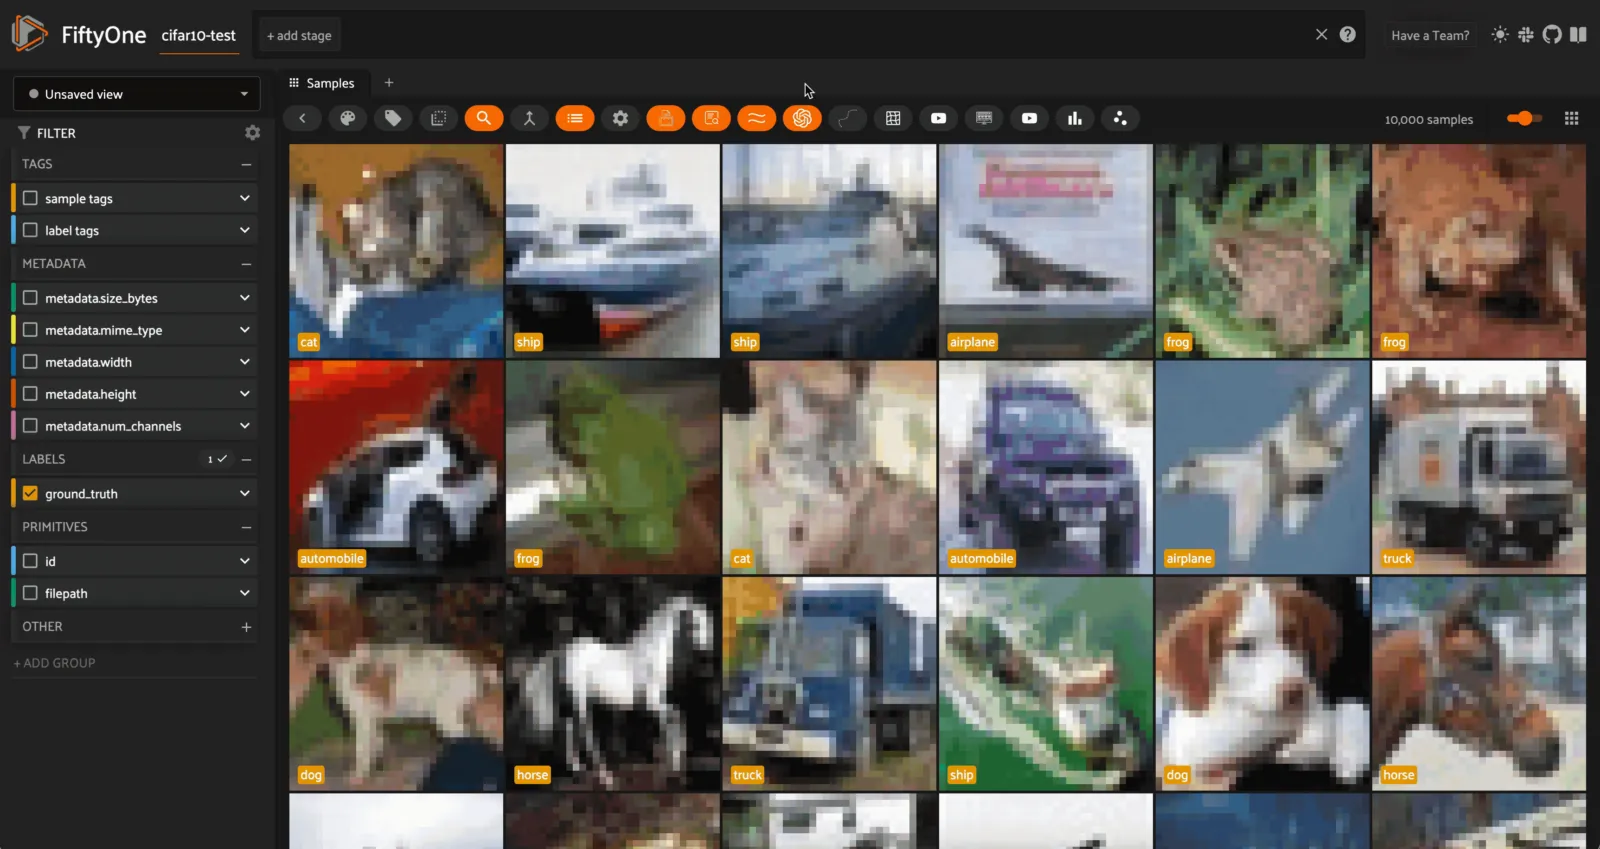

We can color by any attribute on our samples — in this case the ground truth label — and filter the contents of the sample grid interactively by selecting regions in the embeddings panel.

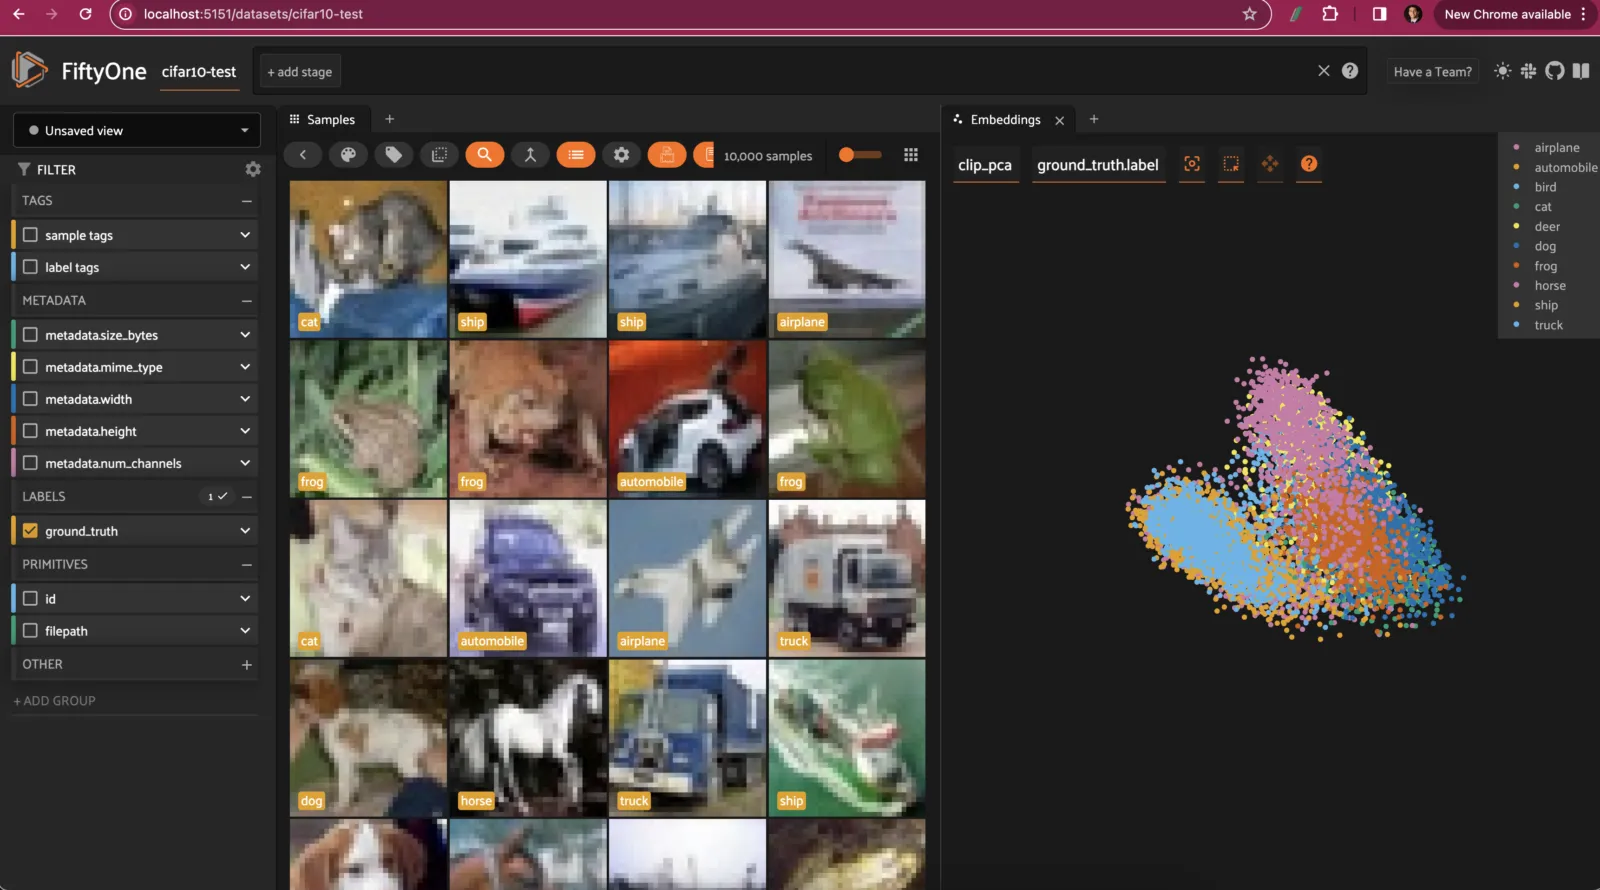

For both the CLIP and ResNet-101 embeddings, the PCA plot does seem to very loosely retain information from the embeddings (and the original images). However, when we color by label, there is substantial overlap from one class to another. 

Restricting the CLIP PCA view to just automobiles, trucks, and ships, we can see that the distributions for all three classes are essentially identical, aside from the ships extending slightly farther out.

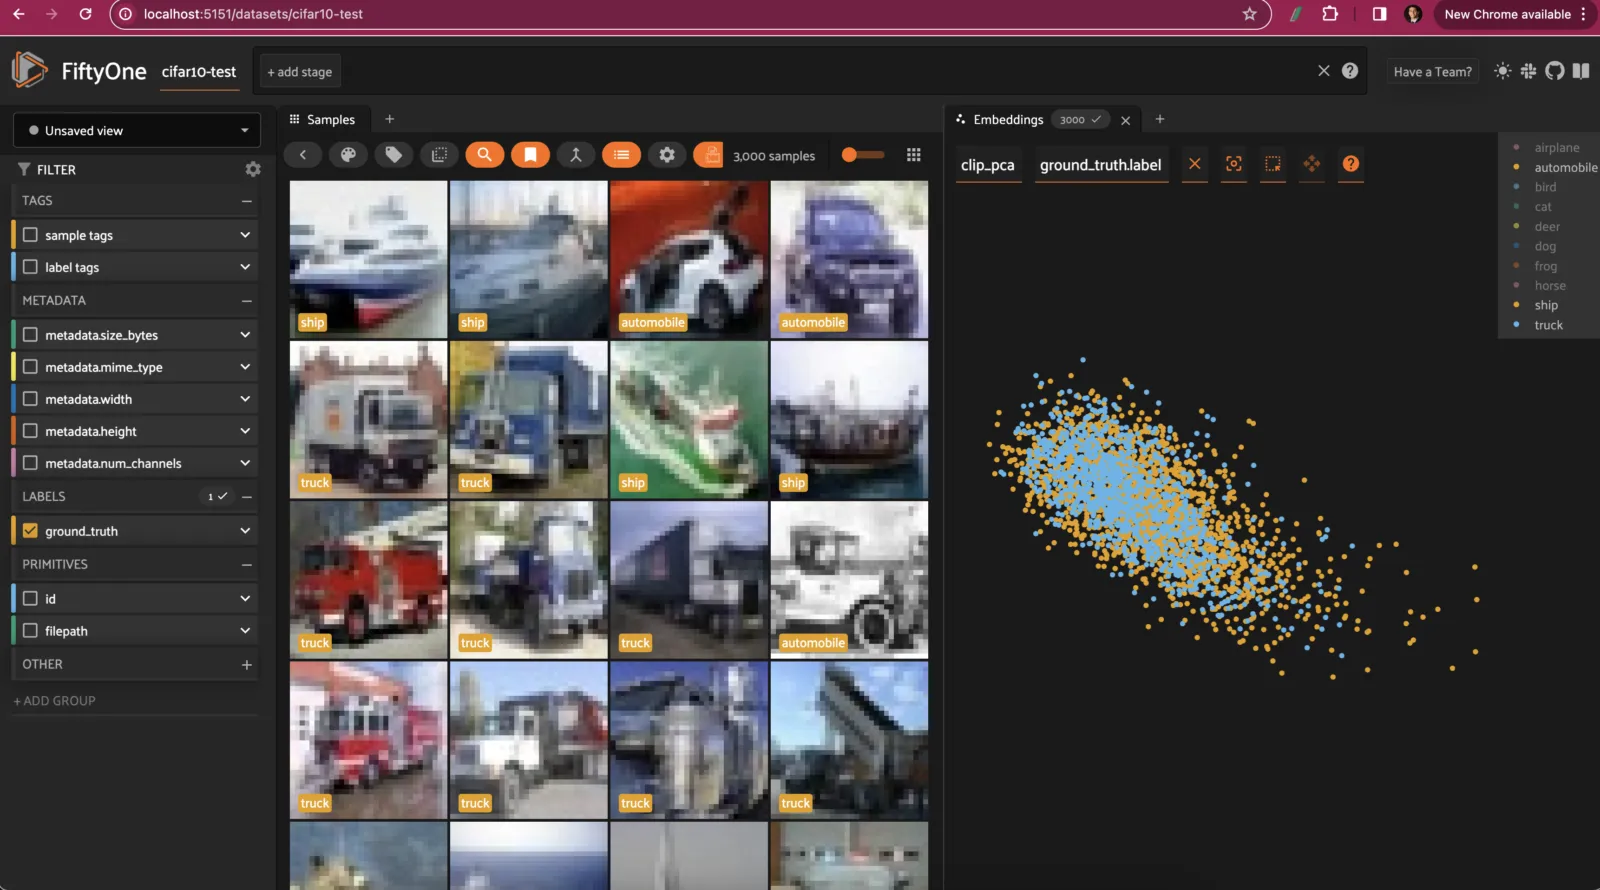

## Dimensionality Reduction with t-SNE

[t-Distributed Stochastic Neighbor Embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), or t-SNE, is a nonlinear dimensionality reduction technique that aims to, roughly speaking, keep neighbors close. More precisely, t-SNE takes the initial, high-dimensional data (in our case embedding vectors) and computes the similarity between inputs. The algorithm then attempts to learn a lower-dimensional representation which preserves as much of the similarity as possible. Mathematically, this learning is achieved by minimizing the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the high-dimensional (fixed) and low-dimensional (trained) distributions.

**Strengths**

- t-SNE is nonlinear, making it a much better fit for (embeddings computed on) datasets like MNIST and CIFAR-10. 
- The technique is good at preserving local structure, making it easy to see clustering in data!

**Limitations**

- t-SNE relies on random initialization, so good fits are not guaranteed
Still sensitive to outliers
- Not scalable: for a dataset with n samples, t-SNE takes $\mathcal{O}(n^2)$ time to run, and requires $\mathcal{O}(n^2)$ space to operate


### Running t-SNE on Embeddings

Like PCA, t-SNE is natively supported by the FiftyOne Brain’s `compute_visualization()`, so we can run dimensionality reduction on our embeddings by passing `method="tsne"`:

In [ ]:
## t-SNE with ResNet101 embeddings
fob.compute_visualization(
    dataset, 
    embeddings="resnet101_embeddings", 
    method="tsne", 
    brain_key="resnet101_tsne"
)

## t-SNE with CLIP embeddings
fob.compute_visualization(
    dataset, 
    embeddings="clip_embeddings", 
    method="tsne", 
    brain_key="resnet101_tsne"
)

session = fo.launch_app(dataset)

Looking at the results of t-SNE dimensionality reduction on both ResNet-101 and CLIP embeddings, we can see a lot more separation between the distributions of different classes.

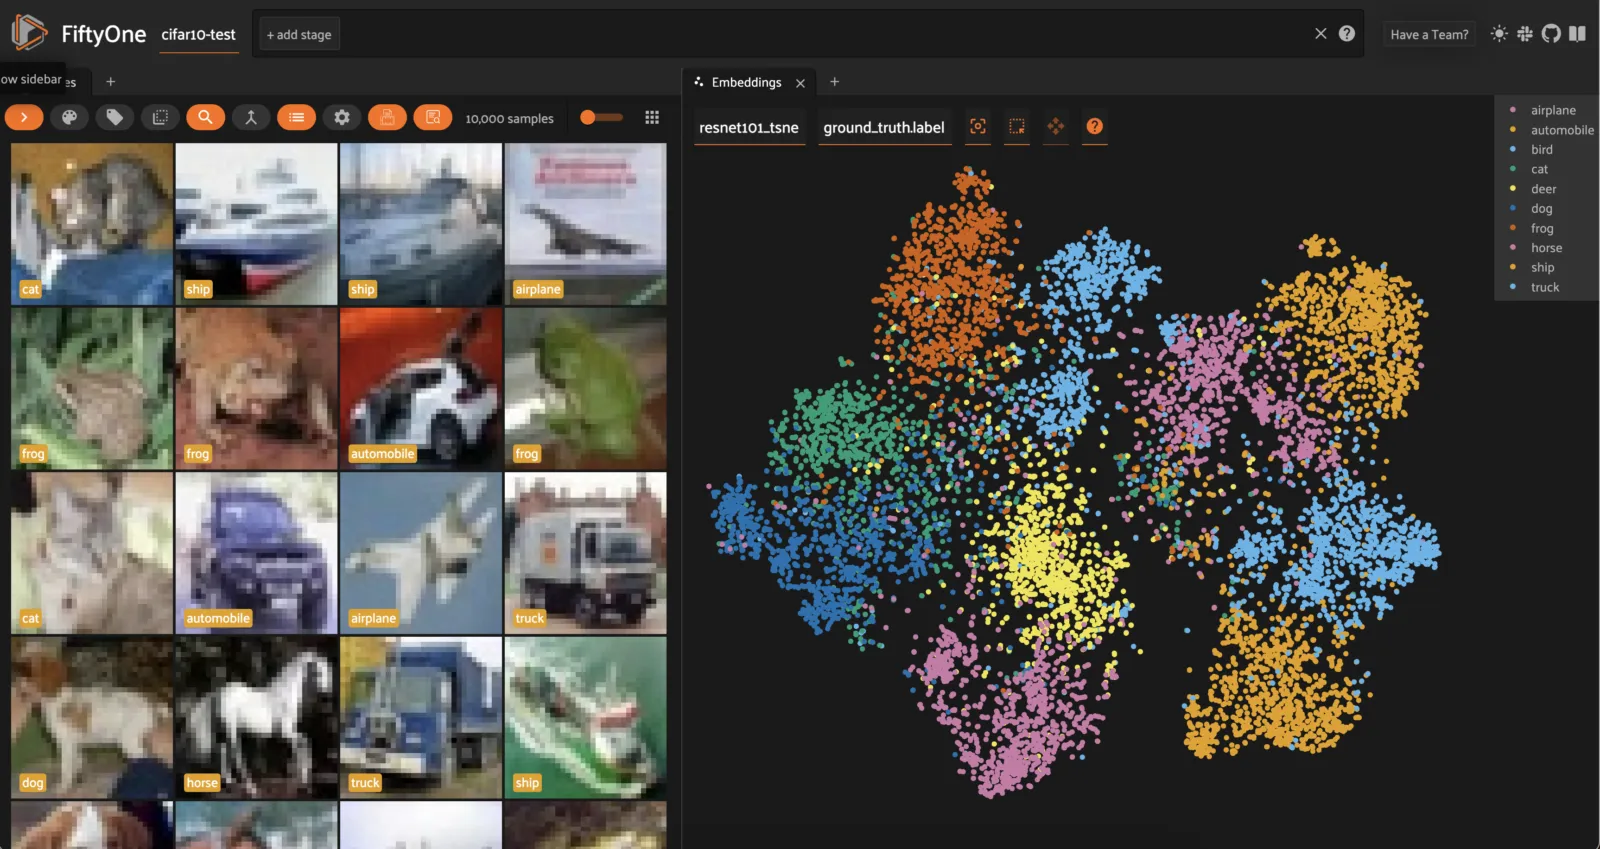

In both cases, similar classes are still close to each other — for instance, automobiles and trucks are adjacent — but we can also mostly distinguish a main cluster for almost every class. In other words, t-SNE does a very good job at capturing local structure, and a decent job at capturing global structure.

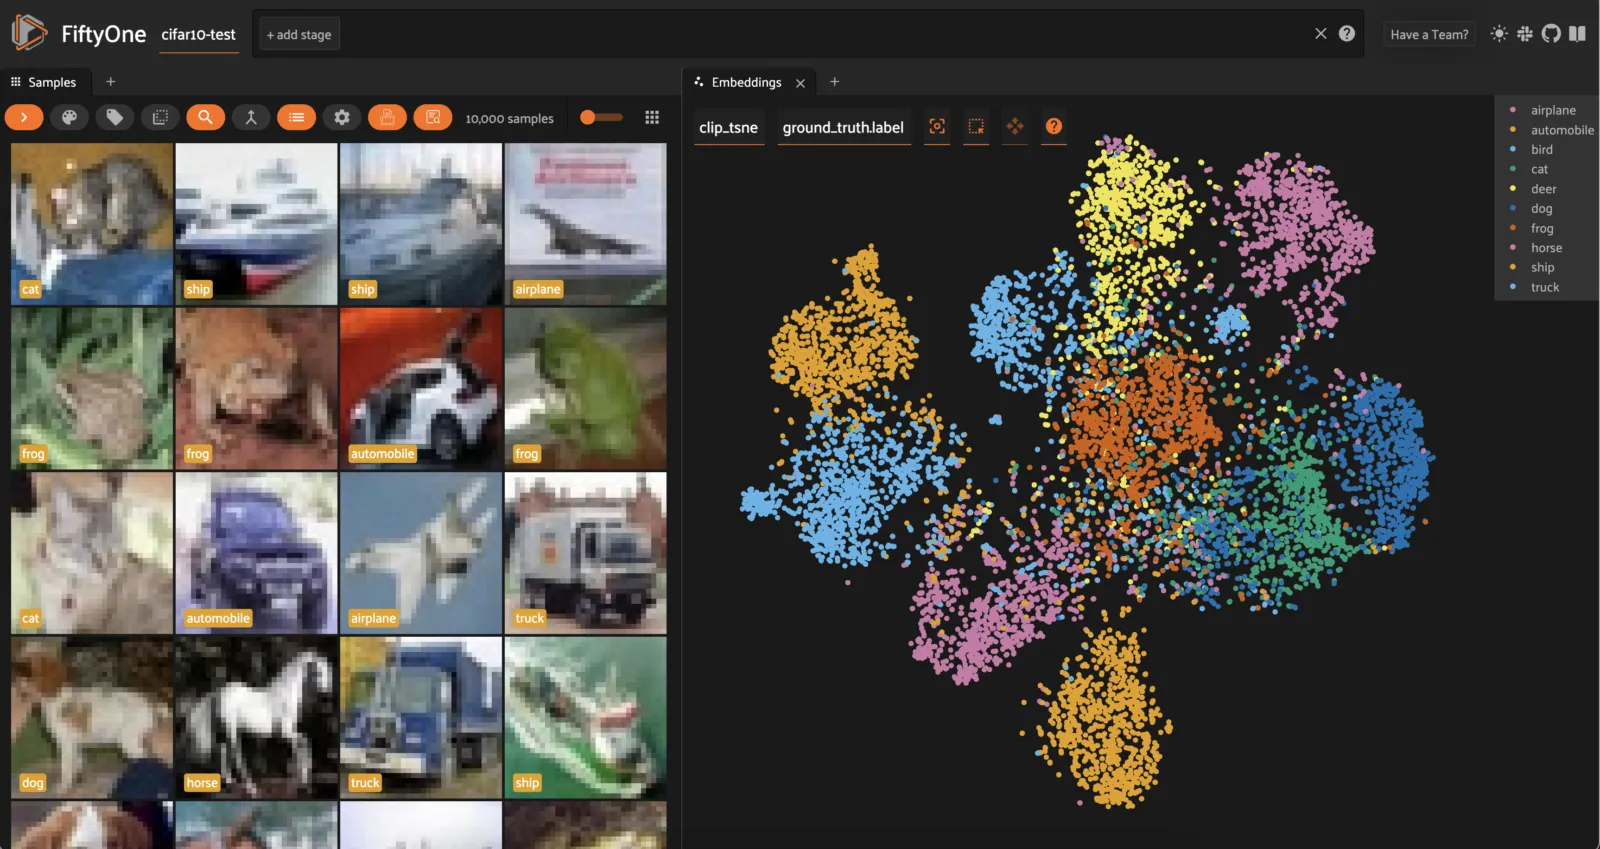

## Dimensionality Reduction with UMAP

[Uniform Manifold Approximation and Projection](https://umap-learn.readthedocs.io/en/latest/) (UMAP) is a nonlinear dimensionality reduction technique based on the mathematics of [topology](https://en.wikipedia.org/wiki/Topology). I won’t go into the gory details, as there is an excellent visual explanation of the approach [here](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html), but in essence, UMAP treats the input data as points lying on a special kind of surface called a manifold (technically here a [Riemannian manifold](https://en.wikipedia.org/wiki/Riemannian_manifold)), and tries to learn a lower dimensional representation of the manifold. This explicitly takes global structure into consideration, as opposed to t-SNE, which concerns itself with keeping neighbors close (local structure).

**Strengths**

- Preserves both global and local structure
- Better scaling than t-SNE with dataset size

**Limitations**

- Like t-SNE, UMAP relies on randomness, and is dependent upon hyperparameters
- UMAP assumes that the manifold is locally connected. This can cause problems if there are a few data points that are very far away from the rest of the data.

### Running UMAP on Embeddings

Like PCA and t-SNE, UMAP  is natively supported by the FiftyOne Brain’s `compute_visualization()`, so we can run dimensionality reduction on our embeddings by passing `method="umap"`:

In [ ]:
## UMAP with ResNet101 embeddings
fob.compute_visualization(
    dataset, 
    embeddings="resnet101_embeddings", 
    method="umap", 
    brain_key="resnet101_umap"
)

## UMAP with CLIP embeddings
fob.compute_visualization(
    dataset, 
    embeddings="clip_embeddings", 
    method="umap", 
    brain_key="resnet101_umap"
)

session = fo.launch_app(dataset)

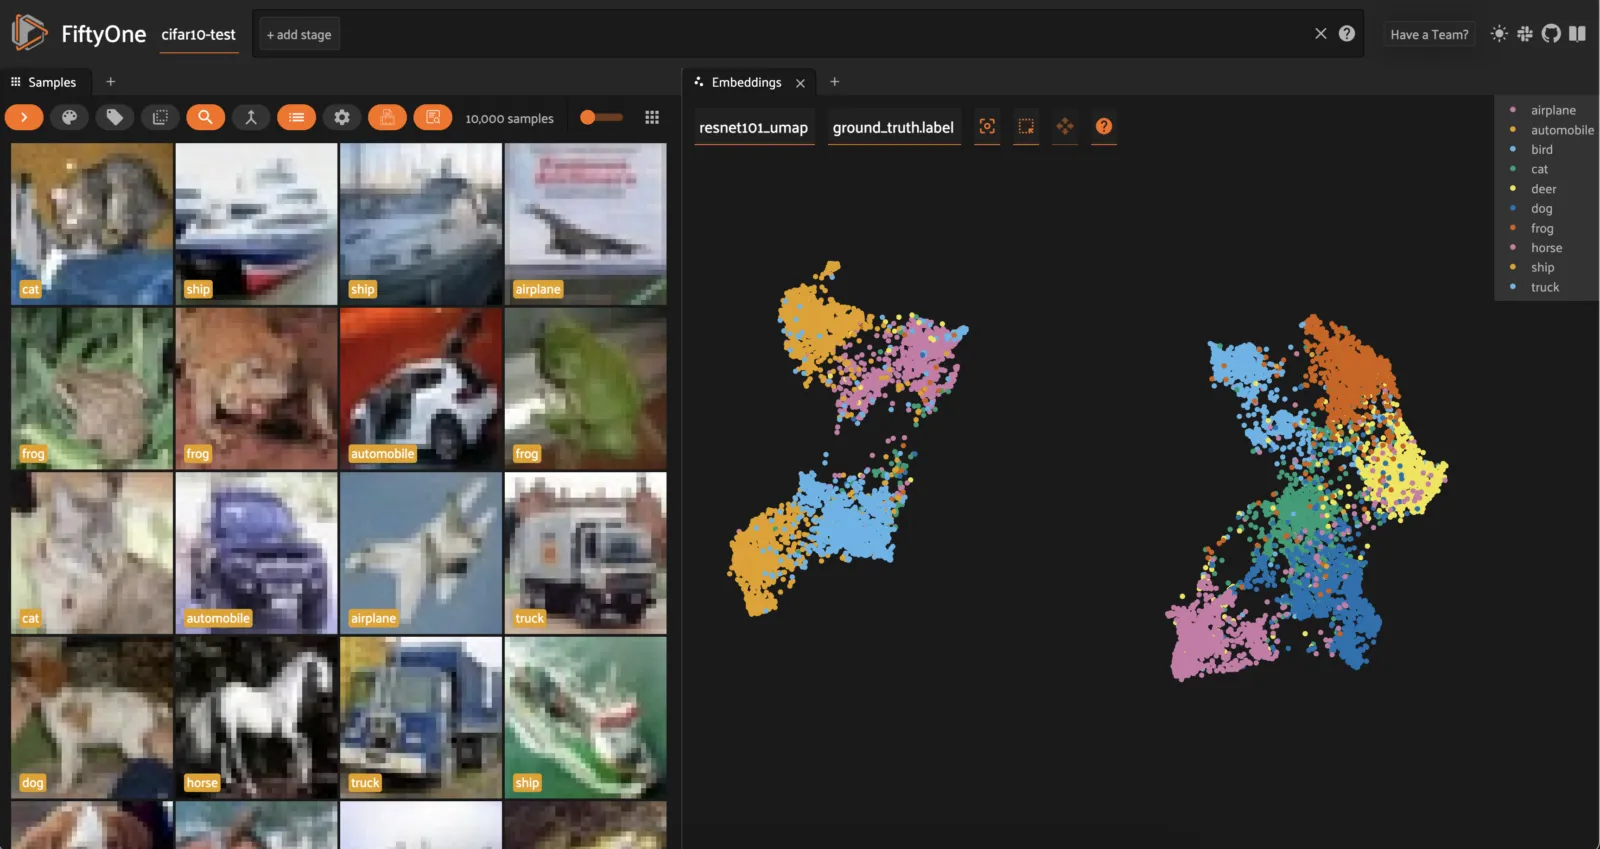

For both sets of embeddings, the clusters are a lot more spread out than with t-SNE. For ResNet-101, all of the vehicles (automobile, truck, airplane, ship) are in one mega-cluster — or two smaller clusters, depending on how you view it — and all of the animals are in another mega-cluster. 

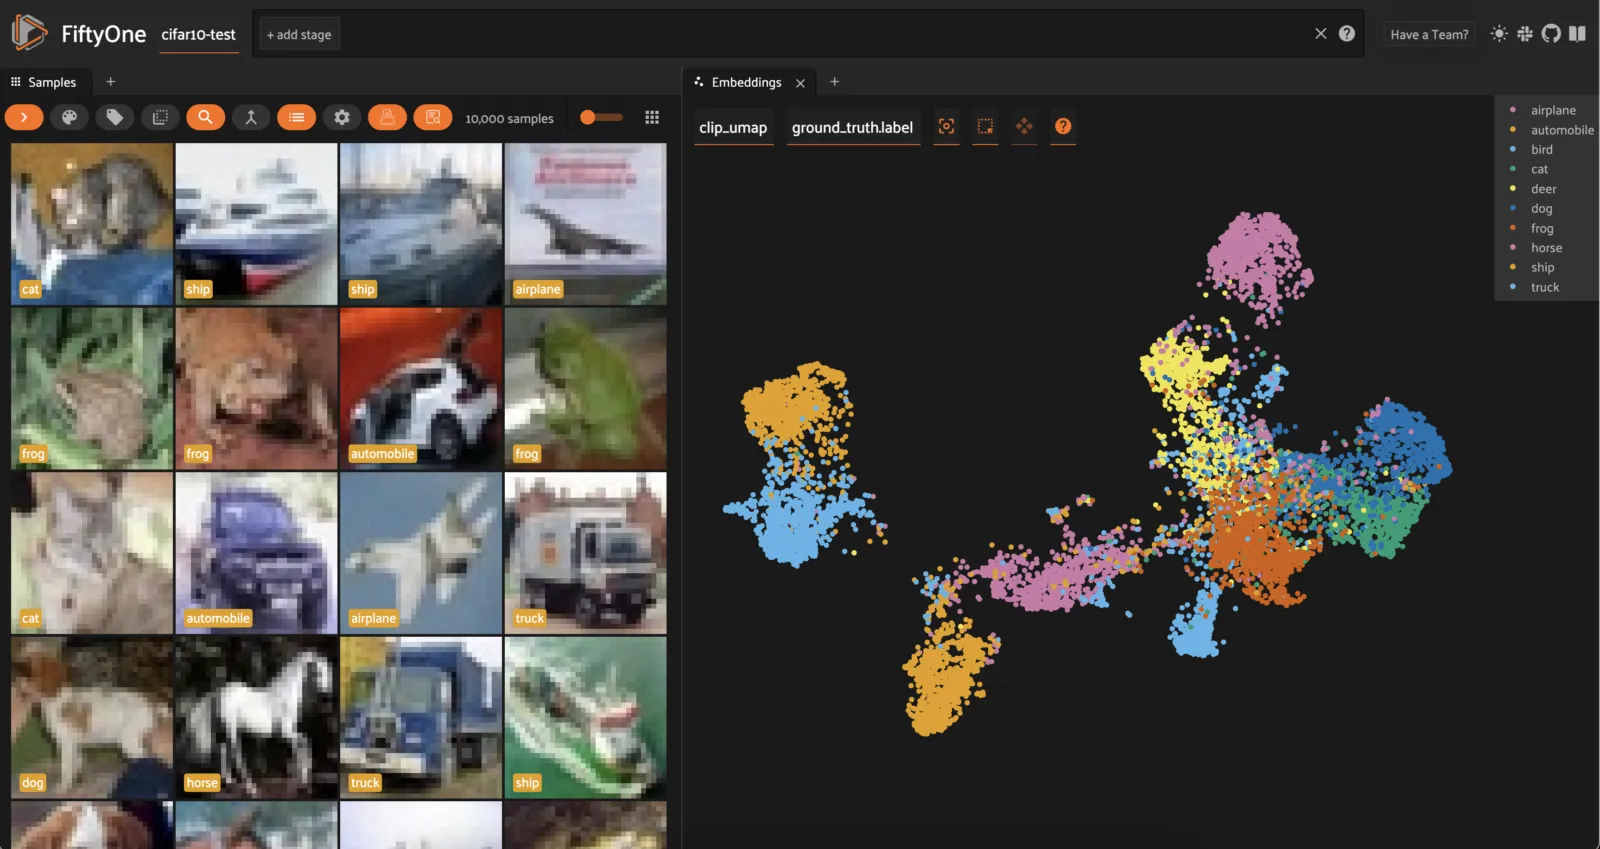

Interestingly, for the CLIP embeddings, we see that the `airplane` cluster is situated close to both `bird` and `ship`. The `car` and `truck` clusters are very close together; and the `cat` and `dog` clusters are very close together.

## Dimensionality Reduction with Custom Methods

Depending on the specific structure of your data, you may find that none of the techniques detailed above provide an intuitive view into your data. Fortunately, there are tons of other techniques you can use. In this section, we’ll show you how to run custom dimensionality reduction techniques with FiftyOne.

### Isomap

Like UMAP, Isomap is also a nonlinear manifold learning technique. Isomap is built into scikit-learn, so we can fit our high-dimensional data and generate low-dimensional transformed data points as follows:

In [ ]:
import numpy as np
from sklearn.manifold import Isomap

## get embeddings from dataset
embeddings = np.array(dataset.values("resnet101_embeddings"))

## create and fit
manifold_embedding = Isomap(n_components=2)
z = manifold_embedding.fit_transform(embeddings)

We can then create a visualization in FiftyOne by passing `method=’manual’` into `compute_visualization()` and providing these lower-dimensional points via the `points` argument:

In [ ]:
fob.compute_visualization(
    dataset,
    method='manual',
    points=z,
    brain_key='resnet101_isomap'
)

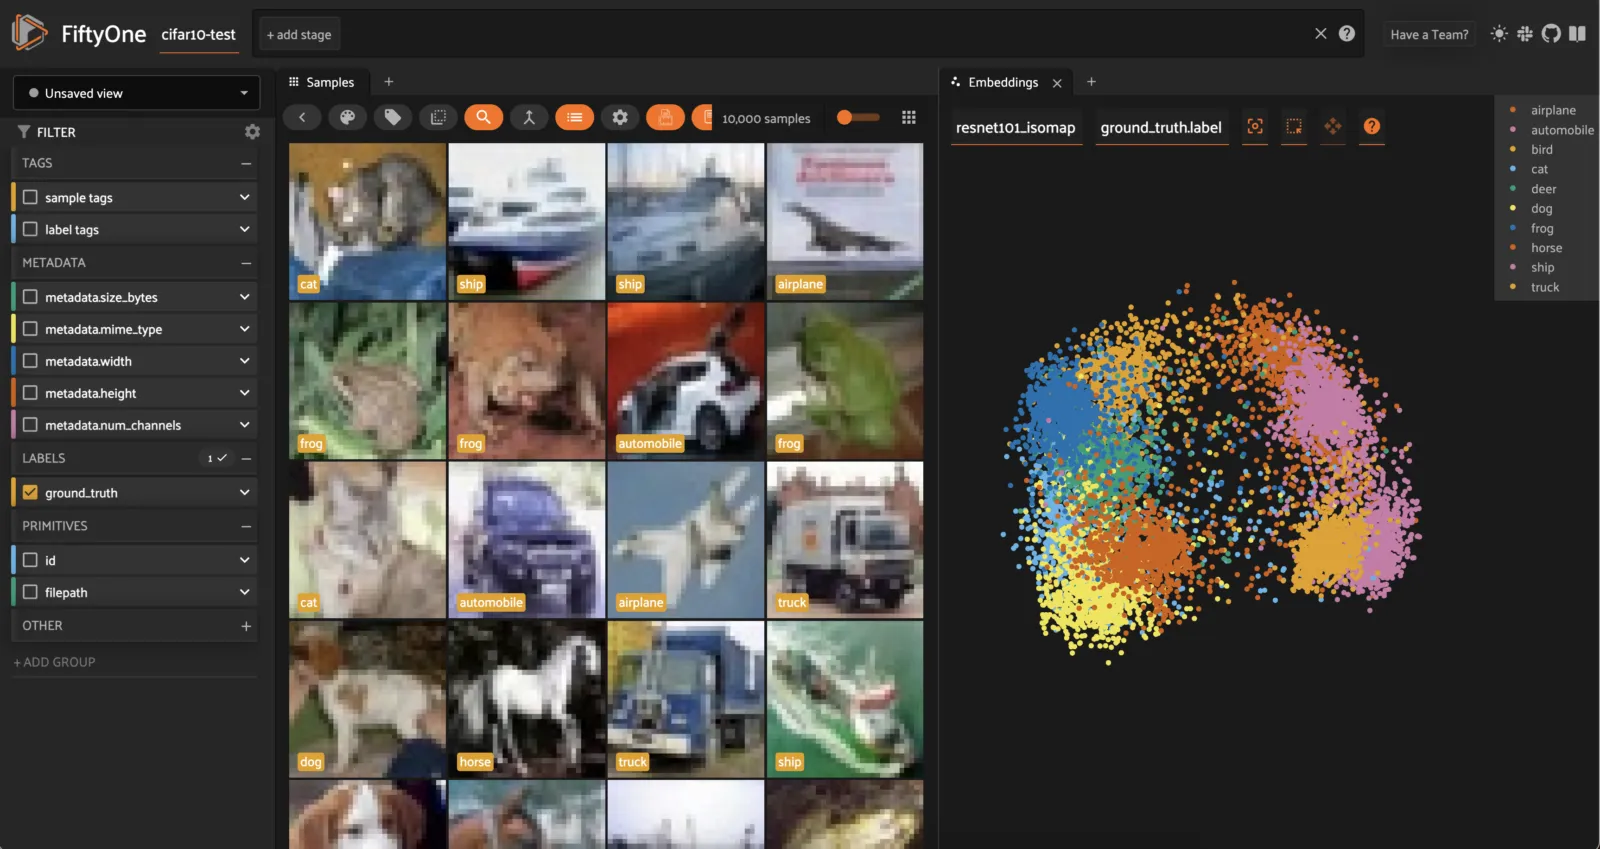

Any dimensionality reduction method supported by scikit-learn can be used in analogous fashion.

### CompressionVAE

[CompressionVAE](https://github.com/maxfrenzel/CompressionVAE) uses Variational Autoencoders to deterministically and reversibly transform the high-dimensional data into a lower dimensional space.

To run CompressionVAE, clone this forked repo:

In [ ]:
!git clone https://github.com/jacobmarks/CompressionVAE.git

Then `cd` into the directory and install the package locally:

In [ ]:
!cd CompressionVAE
!pip install .

Embed the input data (embeddings) into a lower-dimensional space, and create a visualization in FiftyOne via the same `manual` method:

In [ ]:
from cvae import cvae

X = np.array(dataset.values("clip_embeddings"))
embedder = cvae.CompressionVAE(X)
embedder.train()
z = embedder.embed(X)

fob.compute_visualization(
    dataset,
    method='manual',
    points=z,
    brain_key='clip_cvae'
)

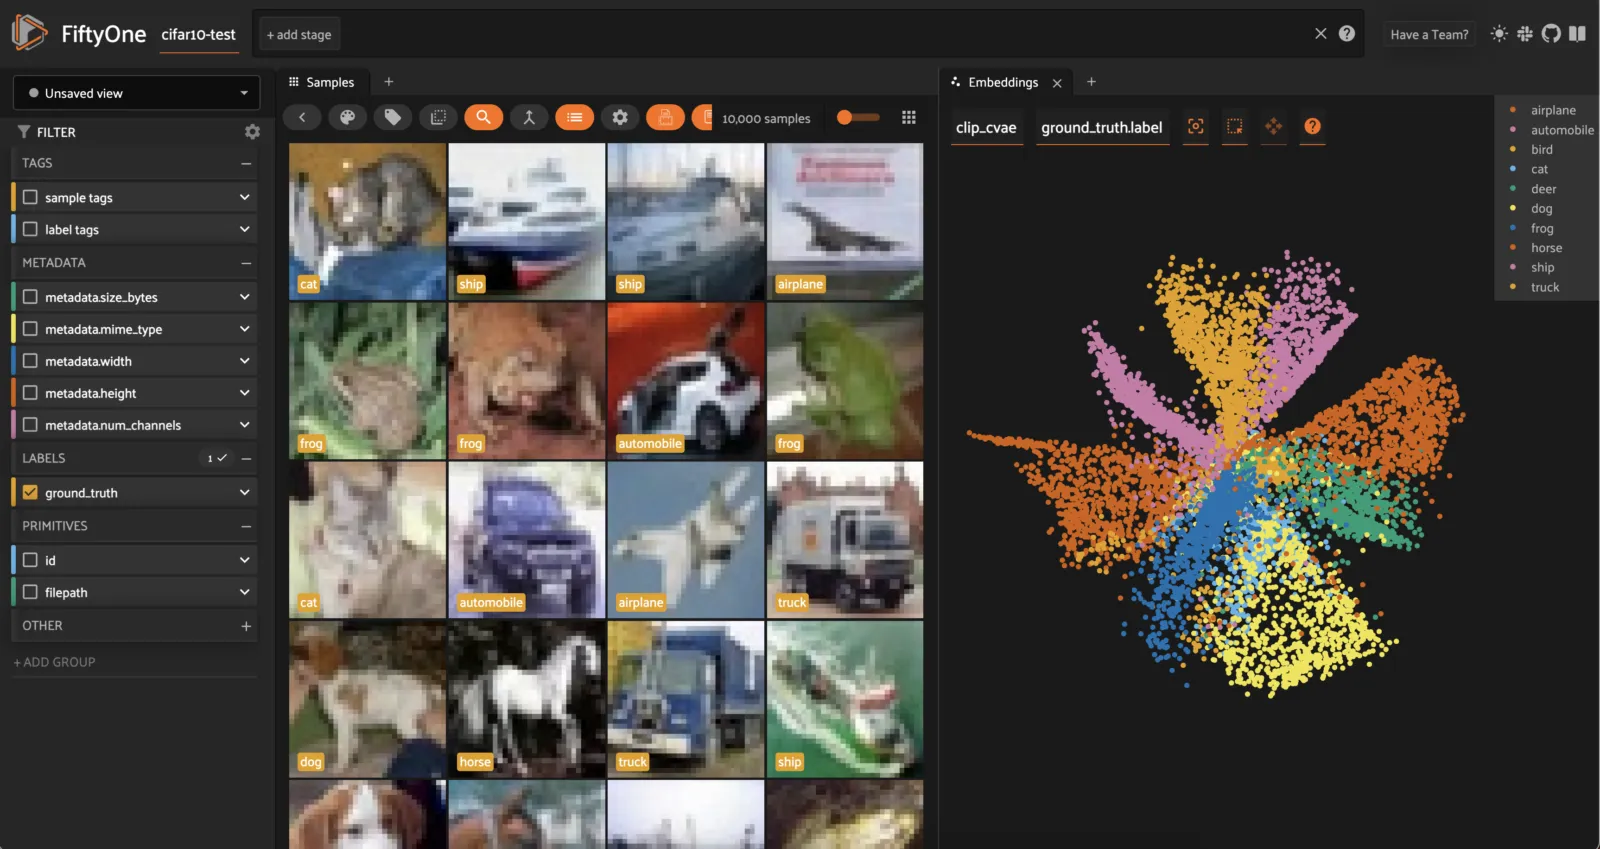

## Advanced Dimensionality Reduction in FiftyOne

### Registerting Custom Visualization Methods

If you find yourself running the same custom dimensionality reduction technique like Isomap or CompressionVAE over and over again, you can create a custom visualization config to make your life easier. This is done by subclassing the [VisualizationConfig](https://docs.voxel51.com/api/fiftyone.brain.visualization.html#fiftyone.brain.visualization.VisualizationConfig) and [Visualization](https://docs.voxel51.com/api/fiftyone.brain.visualization.html#fiftyone.brain.visualization.Visualization) classes.

Here's a simple example using Isomap:

In [ ]:
import numpy as np
from sklearn.manifold import Isomap

import fiftyone as fo
import fiftyone.brain as fob

class IsomapVisualizationConfig(fob.VisualizationConfig):
    def __init__(self, n_neighbors=5, **kwargs):
        super().__init__(**kwargs)
        self.n_neighbors = n_neighbors


class IsomapVisualization(fob.Visualization):
    def fit(self, embeddings):
        manifold_embedding = Isomap(
            n_components=2, 
            n_neighbors=self.config.n_neighbors
        )
        return manifold_embedding.fit_transform(embeddings)

You can then use this by passing in the new visualization config in for the `method` argument:

In [ ]:
dataset = foz.load_zoo_dataset("quickstart")

model = foz.load_zoo_model("clip-vit-base32-torch")
embeddings = dataset.compute_embeddings(model)

results2 = fob.compute_visualization(
    dataset,
    embeddings=embeddings,
    method=IsomapVisualizationConfig,
    brain_key="isomap",
)

### Dimensionality Reduction with Object Patches

All of the dimensionality reduction techniques we have discussed so far have been applied to embeddings computed on entire images. However, you can also apply dimensionality reduction to embeddings computed on object patches. This can be useful if you want to visualize the relationships between objects in your images.

To do this, pass in the name of the field containing the object patches you would like to reduce via the `patches_field` argument.

In [ ]:
import fiftyone as fo
import fiftyone.brain as fob
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("quickstart")

fob.compute_visualization(
    dataset,
    patches_field="ground_truth",
    method="umap",
    brain_key="gt_umap"
)

## Summary

Dimensionality reduction is critical to understanding our data, and our models. But it is important to think of dimensionality reduction not just as a single tool, but rather as a collection of techniques. Each technique has its own advantages; and each method projects certain assumptions onto the data, which may or may not hold for your data. I hope this walkthrough helps you to see your data in a new way!